In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_WAIT_POLICY"] = "PASSIVE"

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import torchmetrics

In [2]:
# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import pandas as pd
import numpy as np
import math
from typing import Tuple, Set, List, Union

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import seaborn as sns
from pprint import pprint

import torch
import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayWindowDataset])

from tqdm.auto import tqdm

import io
import json
from PIL import Image
import IPython.display as disp

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage

In [3]:
device               = params.device
ticker               = params.ticker
save_path            = params.save_path

sess_start           = params.sess_start
sess_end             = params.sess_end

look_back            = params.look_back_tick
sess_start_pred      = params.sess_start_pred_tick

n_trials = 10
n_jobs = 1

In [4]:
df_feat = pd.read_csv(params.feat_csv, index_col=0, parse_dates=True)
df_feat

,open,high,low,close,volume,atr_14,ma_5,ma_20,ma_diff,macd_12_26,...,bb_width_20,stoch_k_14,stoch_d_3,in_trading,hour,day_of_week,month,bid,ask,signal
2004-01-02 13:09:00,-0.193147,-0.317313,-0.028125,-0.193762,-0.319224,-1.435516,-0.185561,-0.282361,0.123688,0.202706,...,-0.929333,-1.481580,-1.561625,0,0.493,-0.976,0.351,0.763664,0.764807,0.005593
2004-01-02 13:10:00,-0.201085,-0.324262,-0.037500,-0.201725,-0.283773,-1.432540,-0.192087,-0.284115,0.112444,0.193448,...,-0.921566,-1.481580,-1.561625,0,0.493,-0.976,0.351,0.763647,0.764790,0.006095
2004-01-02 13:11:00,-0.209022,-0.331210,-0.046875,-0.209688,-0.248322,-1.429563,-0.200245,-0.286307,0.098388,0.183174,...,-0.913246,-1.481580,-1.561625,0,0.493,-0.976,0.351,0.763631,0.764773,0.006642
2004-01-02 13:12:00,-0.216960,-0.338159,-0.056250,-0.217651,-0.212872,-1.426587,-0.208402,-0.288939,0.085270,0.172220,...,-0.904541,-1.481580,-1.561625,0,0.493,-0.976,0.351,0.763614,0.764757,0.007239
2004-01-02 13:13:00,-0.224897,-0.345107,-0.065625,-0.225614,-0.177421,-1.423611,-0.216560,-0.292008,0.073088,0.160859,...,-0.895592,-1.481580,-1.561625,0,0.493,-0.976,0.351,0.763597,0.764740,0.007889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.475806,0.704918,0.500000,0.705997,5.467381,2.024482,0.367023,-0.130453,2.191746,1.957857,...,0.122381,0.619888,0.342752,1,-0.939,0.039,0.146,196.667400,196.962600,0.000000
2025-06-18 20:57:00,0.685484,0.836066,0.387097,0.478780,6.628840,2.207440,0.460866,-0.093452,2.466615,1.999189,...,0.187641,0.223810,0.415204,1,-0.939,0.039,0.146,196.527500,196.822500,0.000000
2025-06-18 20:58:00,0.467742,0.508197,0.500000,0.470665,7.630343,2.216153,0.497086,-0.060109,2.478653,2.004989,...,0.241322,0.209943,0.370103,1,-0.939,0.039,0.146,196.522500,196.817500,0.000000
2025-06-18 20:59:00,0.475806,0.524590,-0.129032,-0.227217,31.658646,2.487280,0.408182,-0.062549,2.057321,1.614144,...,0.245429,-0.982637,-0.192907,1,-0.939,0.039,0.146,196.092800,196.387200,0.043551


Model selected: dfs_training/AAPL_0.1818.pth 

{'ATT_DROPOUT': 0.1,
 'ATT_HEADS': 16,
 'CLIPNORM': 1.0,
 'CLS_LOSS_WEIGHT': 0.5,
 'DROPOUT_LONG': 0.1,
 'DROPOUT_SHORT': 0.1,
 'EARLY_STOP_PATIENCE': 15,
 'ETA_MIN': 1e-05,
 'HUBER_BETA': 0.5,
 'INITIAL_LR': 0.001,
 'LONG_UNITS': 128,
 'LR_EPOCHS_WARMUP': 5,
 'MAX_EPOCHS': 90,
 'MIN_LR': 1e-06,
 'NUM_WORKERS': 2,
 'PLATEAU_FACTOR': 0.9,
 'PLATEAU_PATIENCE': 0,
 'PLAT_EPOCHS_WARMUP': 999,
 'SHORT_UNITS': 128,
 'TRAIN_BATCH': 16,
 'TRAIN_PREFETCH_FACTOR': 1,
 'T_0': 90,
 'T_MULT': 1,
 'VAL_BATCH': 1,
 'WEIGHT_DECAY': 1e-05}


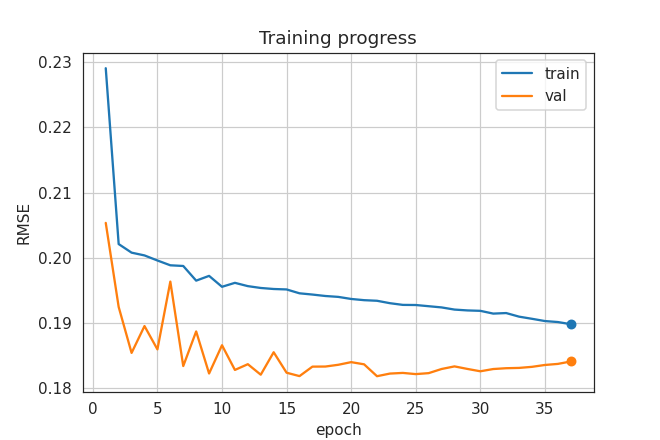

DualMemoryLSTM(
  (conv): Conv1d(15, 15, kernel_size=(3,), stride=(1,), padding=(1,))
  (short_lstm): LSTM(15, 64, batch_first=True, bidirectional=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (do_short): Dropout(p=0.1, inplace=False)
  (ln_short): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (do_long): Dropout(p=0.1, inplace=False)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=128, out_features=1, bias=True)
  (cls_head): Linear(in_features=128, out_features=1, bias=True)
)

In [6]:
model_path = min(
    save_path.glob(f"{ticker}_*.pth"),
    key=lambda p: float(p.stem.split("_")[-1])
)
print('Model selected:', model_path,'\n')

# Load the entire model object (architecture + weights)# 1) load your checkpoint dict
ckpt = torch.load(model_path, map_location=device, weights_only=False)

# 2) grab the full model object you saved
model_best = ckpt["model_obj"]

# 3) move to device and set eval mode
model_best = model_best.to(device).eval()

# 4) show parameters, training plot, and model
saved_hparams = ckpt["hparams"]
pprint(saved_hparams)

png_bytes = ckpt.get("train_plot_png")
img = Image.open(io.BytesIO(png_bytes))
disp.display(img)

model_best


In [7]:
print('executing <build_lstm_tensors>...')
X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
    df            = df_feat,
    look_back     = look_back,
    features_cols = params.features_cols_tick,
    label_col     = params.label_col,
    sess_start    = False # predictions from sess_start_pred
)

print('executing <chronological_split>...')
(X_tr, y_tr), \
(X_val, y_val), \
(X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = models.chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df_feat,
    look_back    = look_back,
    train_prop   = params.train_prop,
    val_prop     = params.val_prop,
    train_batch  = params.hparams['TRAIN_BATCH'],
    sess_start   = False # predictions from sess_start_pred
)

print('executing <split_to_day_datasets>...')
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # Training split arrays (from chronological_split)
    X_tr, y_tr, day_id_tr,
    # Validation split arrays
    X_val, y_val, day_id_val,
    # Test split arrays + raw prices for post‐tracking
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    # Original minute‐bar DataFrame for weekday mapping
    df=df_feat,
    train_batch=params.hparams['TRAIN_BATCH'],
    train_workers=params.hparams['NUM_WORKERS'],
    train_prefetch_factor=params.hparams['TRAIN_PREFETCH_FACTOR']
)

print('dataloaders generated!')

executing <build_lstm_tensors>...


Counting valid windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

executing <chronological_split>...
executing <split_to_day_datasets>...
▶️ Entered split_to_day_datasets
1) building weekday arrays
   Weekdays counts → tr=1593707, val=336375, te=340421
2) moving all splits to CPU
   CPU casts done
3) zero-bas­ing day_id for val & test
   val_day_id ∈ [0..798], total days=799
   te_day_id  ∈ [0..808], total days=809
4) instantiating DayWindowDatasets
   ds_tr days: 3792
   ds_val days: 799
   ds_te days: 809
5) building DataLoaders
   train_loader ready
   val_loader ready
   test_loader ready
dataloaders generated!


In [8]:
# zero‐forecast baseline on val vs test
# √( mean( (yᵢ – 0)² ) )

val_baseline  = models.naive_rmse(val_loader)
test_baseline = models.naive_rmse(test_loader)

print(f"Val zero‐forecast baseline RMSE  = {val_baseline:.5f}")
print(f"Test zero‐forecast baseline RMSE = {test_baseline:.5f}")

Val zero‐forecast baseline RMSE  = 0.28519
Test zero‐forecast baseline RMSE = 0.27331


std val: 0.21367605
std test: 0.20394681


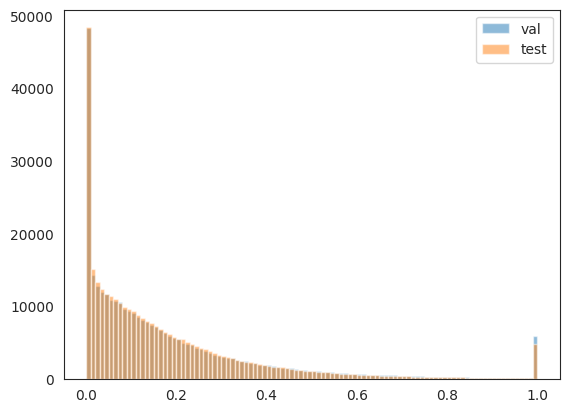

In [9]:
# to confirm the baseline proportions, calculate the STD
# σ = √( mean( (yᵢ – ȳ)² ) )

y_vals = np.concatenate([batch[1].view(-1).numpy()
                         for batch in val_loader])
y_tes  = np.concatenate([batch[1].view(-1).numpy()
                         for batch in test_loader])
print("std val:", np.std(y_vals))
print("std test:", np.std(y_tes))

plt.hist(y_vals, bins=100, alpha=0.5, label="val")
plt.hist(y_tes,  bins=100, alpha=0.5, label="test")
plt.legend(); plt.show()

In [20]:
import numpy as np
import torch
import torchmetrics
from tqdm import tqdm
from typing import Tuple

def evaluate_model(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    device: torch.device,
    split_name: str
) -> Tuple[float, np.ndarray]:
    """
    Compute fast per-day RMSE and collect regression predictions for a two-headed sequence model.

    This function reproduces the validation‐phase logic exactly, with the following features:

    1. Batch handling
       - Expects each batch from `loader` to contain at least:
         (x_reg, y_reg, y_cls, weekday, *extras)
       - `*extras` can include masks, padding lengths, etc., and will be ignored here.

    2. Device placement
       - Moves all required tensors (x_reg, y_reg, weekday) to the specified `device`.
       - Uses non_blocking=True for maximal throughput when pinned memory is enabled.

    3. Weekday collapse
       - If `weekday` arrives as shape (B, W), reduces it to (B,) by taking the first time‐step.
       - This gives one day identifier per sliding window sequence.

    4. Hidden‐state management
       - Calls `model.reset_short()` before each new (W, look_back, F) sequence to clear
         intra‐day state.
       - If the current `day_id` is less than the previous, calls `model.reset_long()`
         to clear inter‐day state, mirroring a day rollover.

    5. Two‐headed forward pass
       - Invokes `model(x_day)`, receiving a tuple:
           pred_reg : Tensor shaped (W, look_back, 1)
           pred_cls : classification head output (ignored here)
       - Extracts the final look_back timestep from the regression head:
           pred_day = pred_reg[:, -1, 0]   # shape (W,)

    6. RMSE accumulation
       - Uses `torchmetrics.MeanSquaredError(squared=False)` to incrementally
         compute root‐mean‐squared error across all windows.
       - Updates the metric with `rmse_metric.update(pred_day, y_day)`.

    7. Prediction collection
       - Appends each `pred_day` (moved to CPU & numpy) into `all_preds`.
       - After looping, concatenates into a single array in loader emission order.

    8. Summary output
       - Prints a line: “[split_name] RMSE over [total_windows] windows = [rmse:.5f]”.


    Returns
    -------
    rmse : float
        Final root‐mean‐squared error computed over all sliding windows.
    preds : np.ndarray, shape (total_windows,)
        Concatenated per-window regression predictions in loader order.
    """
    # Put model into eval mode on the correct device
    model.to(device)
    model.eval()

    # Clear any existing LSTM hidden states
    model.h_short = model.h_long = None

    prev_day_id   = None       # Tracks the previous window’s day to detect rollovers
    total_windows = 0          # Counter for total number of sliding windows processed
    all_preds     = []         # Container for per-window predictions

    # Initialize RMSE metric (square root of MSE)
    rmse_metric = torchmetrics.MeanSquaredError(squared=False).to(device)
    rmse_metric.reset()

    with torch.no_grad():
        # Iterate over the dataset split with a progress bar
        for batch in tqdm(loader, desc=split_name, unit="batch"):
            # Unpack at least the first four elements; ignore any extras
            xb, yb, yb_cls, wd, *extras = batch

            # Transfer to device with non-blocking copy if possible
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            wd = wd.to(device, non_blocking=True)

            # If weekday is shape (B, W), compress to one ID per sequence
            if wd.dim() > 1:
                wd = wd[:, 0]

            B, W = xb.size(0), xb.size(1)

            # Process each sample (sliding-window sequence) in the batch
            for i in range(B):
                x_day  = xb[i]                # (W, look_back, F)
                y_day  = yb[i].view(-1)       # (W,)
                day_id = int(wd[i].item())    # scalar day identifier

                # Reset short-term state for each sequence
                model.reset_short()
                # Reset long-term state on day rollover
                if prev_day_id is not None and day_id < prev_day_id:
                    model.reset_long()
                prev_day_id = day_id

                # Forward pass: get regression and classification heads
                pred_reg, _pred_cls = model(x_day)

                # Extract per-window predictions from the last time-step
                pred_day = pred_reg[:, -1, 0]  # shape (W,)

                # Update RMSE metric and collect predictions
                rmse_metric.update(pred_day, y_day)
                total_windows += y_day.numel()
                all_preds.append(pred_day.cpu().numpy())

    # Compute final RMSE and concatenate all predictions
    rmse  = rmse_metric.compute().cpu().item()
    preds = np.concatenate(all_preds, axis=0)

    # Print a concise summary of results
    print(f"\n{split_name} RMSE over {total_windows} windows = {rmse:.5f}")

    return rmse, preds


In [21]:
train_rmse, train_preds = evaluate_model(
    model_best, train_loader, device,
    split_name="Train"
)
val_rmse, val_preds     = evaluate_model(
    model_best, val_loader,   device,
    split_name="Validation"
)
test_rmse, test_preds   = evaluate_model(
    model_best, test_loader,  device,
    split_name="Test"
)

print("\nTrain preds:", len(train_preds))
print("Val   preds:", len(val_preds))
print("Test  preds:", len(test_preds))

Train: 100%|██████████| 237/237 [00:06<00:00, 34.06batch/s]



Train RMSE over 1596432 windows = 0.19313


Validation: 100%|██████████| 799/799 [00:01<00:00, 488.11batch/s]



Validation RMSE over 336375 windows = 0.18409


Test: 100%|██████████| 809/809 [00:01<00:00, 474.08batch/s]


Test RMSE over 340421 windows = 0.18237

Train preds: 1596432
Val   preds: 336375
Test  preds: 340421


In [22]:
def add_pred_and_split(
    df: pd.DataFrame,
    train_preds: np.ndarray,
    val_preds:   np.ndarray,
    test_preds:  np.ndarray,
    day_id_tr:   np.ndarray,
    day_id_val:  np.ndarray,
    day_id_te:   np.ndarray
) -> Tuple[pd.DataFrame, Set[pd.Timestamp], pd.DataFrame, List[pd.Timestamp]]:
    """
    Attach one‐per‐window predictions to each window‐end bar, then split into
    train+val vs test. Prints detailed counts of kept/dropped windows.

    Returns
    -------
    df_train_val   : DataFrame for train+val days with `pred_signal` set
    train_val_days : set of train+val dates (pd.Timestamp)
    df_test        : DataFrame for test days with `pred_signal` set
    te_days        : sorted list of test dates (pd.Timestamp)
    """

    # 1) Copy input and initialize prediction columns
    df2 = df.copy()
    df2["pred_signal"] = np.nan
    df2["pred_action"] = 0
    print(f"🔍 Original DataFrame has {len(df2)} rows")

    # 2) Map numeric day‐IDs back to actual calendar dates
    days       = df2.index.normalize()
    unique     = sorted(days.unique())
    tr_days    = [unique[i] for i in np.unique(day_id_tr).astype(int)]
    vl_days    = [unique[i] for i in np.unique(day_id_val).astype(int)]
    te_days    = [unique[i] for i in np.unique(day_id_te).astype(int)]
    print(f"• Train days: {len(tr_days)} | Val days: {len(vl_days)} | Test days: {len(te_days)}")

    # 3) Tag each row with its calendar day and per‐day bar count
    df2["day"] = days
    df2["cnt"] = df2.groupby("day").cumcount()
    print("✓ Computed per‐day bar counts (cnt) for look_back filtering")

    # 4) Build mask for valid window‐end bars:
    #    a) timestamp ≥ sess_start_pred
    #    b) have at least look_back bars (cnt ≥ look_back - 1)
    end_mask      = (
        (df2.index.time >= sess_start_pred)
        & (df2["cnt"] >= look_back - 1)
    )
    total_windows = end_mask.sum()
    print(f"⏹ Found {total_windows} window‐end bars after time & look_back filter")

    # 5) Extract index positions for each split
    idx_tr  = df2.index[end_mask & df2["day"].isin(tr_days)]
    idx_val = df2.index[end_mask & df2["day"].isin(vl_days)]
    idx_te  = df2.index[end_mask & df2["day"].isin(te_days)]
    print(f"  – Train idx: {len(idx_tr)} | Val idx: {len(idx_val)} | Test idx: {len(idx_te)}")

    # 6) Helper to trim preds so they align 1:1 with window‐ends
    def _trim(preds: np.ndarray, idx: pd.DatetimeIndex, name: str):
        n_extra = len(preds) - len(idx)
        if n_extra > 0:
            print(f"⚠️  Dropping {n_extra} earliest {name} preds (too many predictions)")
            return preds[n_extra:], idx
        elif n_extra < 0:
            keep = len(preds)
            print(f"⚠️  Only {keep}/{len(idx)} {name} windows have preds (too few predictions)")
            return preds, idx[:keep]
        else:
            print(f"✅ {name.capitalize()} preds match window‐ends exactly ({len(preds)})")
            return preds, idx

    # 7) Trim & assign predictions into df2
    train_preds, idx_tr  = _trim(train_preds, idx_tr,  "train")
    val_preds,   idx_val = _trim(val_preds,   idx_val, "val")
    test_preds,  idx_te  = _trim(test_preds,  idx_te,  "test")

    df2.loc[idx_tr,  "pred_signal"] = train_preds
    df2.loc[idx_val, "pred_signal"] = val_preds
    df2.loc[idx_te,  "pred_signal"] = test_preds
    print("🎯 Stamped all predictions into 'pred_signal' column")

    # 8) Build the final train+val vs test splits
    train_val_days = set(tr_days + vl_days)
    df_train_val   = (
        df2[df2["day"].isin(train_val_days)]
        .drop(columns=["day", "cnt"])
    )
    df_test        = (
        df2[df2["day"].isin(te_days)]
        .drop(columns=["day", "cnt"])
    )
    
    # drop all non‐window-end bars that remained NaN
    df_train_val = df_train_val[df_train_val["pred_signal"].notna()]
    df_test      = df_test     [df_test     ["pred_signal"].notna()]

    print("🏁 Finished. Returning filtered DataFrames (no NaNs in pred_signal).")
    return df_train_val, df_test


In [23]:
df_train_val, df_test = add_pred_and_split(
    df=df_feat,
    train_preds=train_preds,
    val_preds=val_preds,
    test_preds=test_preds,
    day_id_tr=day_id_tr,
    day_id_val=day_id_val,
    day_id_te=day_id_te
)

print('saving the test csv...')
df_test.to_csv(params.pred_csv)

df_train_val

🔍 Original DataFrame has 3601230 rows
• Train days: 3792 | Val days: 799 | Test days: 809
✓ Computed per‐day bar counts (cnt) for look_back filtering
⏹ Found 2270577 window‐end bars after time & look_back filter
  – Train idx: 1593781 | Val idx: 336375 | Test idx: 340421
⚠️  Dropping 2651 earliest train preds (too many predictions)
✅ Val preds match window‐ends exactly (336375)
✅ Test preds match window‐ends exactly (340421)
🎯 Stamped all predictions into 'pred_signal' column
🏁 Finished. Returning filtered DataFrames (no NaNs in pred_signal).
saving the test csv...


,open,high,low,close,volume,atr_14,ma_5,ma_20,ma_diff,macd_12_26,...,stoch_d_3,in_trading,hour,day_of_week,month,bid,ask,signal,pred_signal,pred_action
2004-01-02 14:00:00,-0.597963,-0.671685,-0.506250,-0.599867,1.488767,-1.402778,-0.599973,-0.670029,-1.242828e-13,-0.063516,...,-1.561625,0,0.247,-0.976,0.351,0.762810,0.763953,0.448429,0.401118,0
2004-01-02 14:01:00,-0.605900,-0.678633,-0.515625,-0.607830,1.524218,-1.402778,-0.608131,-0.678800,0.000000e+00,-0.064115,...,-1.561625,0,0.247,-0.976,0.351,0.762794,0.763936,0.488664,0.321013,0
2004-01-02 14:02:00,-0.613838,-0.685582,-0.525000,-0.615793,1.559669,-1.402778,-0.616288,-0.687570,0.000000e+00,-0.064671,...,-1.561625,0,0.247,-0.976,0.351,0.762777,0.763920,0.532508,0.337005,0
2004-01-02 14:03:00,-0.621775,-0.692530,-0.534375,-0.623756,1.595119,-1.402778,-0.624446,-0.696341,-1.242828e-13,-0.065186,...,-1.561625,0,0.247,-0.976,0.351,0.762760,0.763903,0.580285,0.368209,0
2004-01-02 14:04:00,-0.629713,-0.699479,-0.543750,-0.631719,1.630570,-1.402778,-0.632604,-0.705112,-1.242828e-13,-0.065663,...,-1.561625,0,0.247,-0.976,0.351,0.762743,0.763886,0.632348,0.348397,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-28 20:56:00,0.736230,0.747917,0.784043,0.790310,2.263197,0.652514,0.741828,0.738415,2.744130e-01,0.321477,...,1.211724,1,-0.939,0.973,0.979,175.238500,175.501500,0.318801,0.150351,0
2022-03-28 20:57:00,0.786714,0.797917,0.841489,0.822932,3.136585,0.765180,0.784641,0.743795,7.438394e-01,0.520116,...,1.289475,1,-0.939,0.973,0.979,175.316000,175.579200,0.224585,0.157026,0
2022-03-28 20:58:00,0.824577,0.839583,0.881915,0.880694,3.910116,0.836338,0.825969,0.753591,1.139913e+00,0.770887,...,1.438055,1,-0.939,0.973,0.979,175.453300,175.716700,0.008583,0.161908,0
2022-03-28 20:59:00,0.881372,0.897917,0.911702,0.882796,9.226442,0.943074,0.855498,0.762535,1.398787e+00,0.960884,...,1.284055,1,-0.939,0.973,0.979,175.458300,175.721700,0.000000,0.168424,0


In [24]:
# Flatten out pandas so we can index by numpy arrays
signals    = df_train_val["pred_signal"].to_numpy(dtype=float)
closes     = df_train_val["close"].to_numpy(dtype=float)
bids       = df_train_val["bid"].to_numpy(float)  
asks       = df_train_val["ask"].to_numpy(float)  
timestamps = df_train_val.index.to_numpy(dtype="datetime64[ns]")

# Build a list of (day, positions) for fast slicing
normed      = df_train_val.index.normalize().to_numpy(dtype="datetime64[ns]")
unique_days = np.unique(normed)
day_positions = [
    (day, np.flatnonzero(normed == day))
    for day in unique_days
]

In [25]:
def objective(trial):
    # 1) Suggest your hyperparameters
    pred_threshold     = trial.suggest_float("pred_threshold",     0.05, 0.95)
    trailing_stop_pred = trial.suggest_float("trailing_stop_pred", 0.01, 0.1)
    stats_list = []

    # 2) Loop day by day, report intermediate P&L to Optuna
    for step, (day, idxs) in enumerate(tqdm(day_positions, desc="Gen+Sim", leave=False), start=1):
        # Slice out one day of signals & closes
        df_day = pd.DataFrame(
            {
                "pred_signal": signals[idxs],
                "close"      : closes[idxs],
                "bid"        : bids[idxs],    
                "ask"        : asks[idxs]
            },
            index=pd.DatetimeIndex(timestamps[idxs])
        )

        # Generate actions and simulate
        df_actions = trades.generate_trade_actions(
            df               = df_day,
            col_signal       = "pred_signal",
            col_action       = "pred_action",
            buy_threshold    = pred_threshold,
            trailing_stop_pct= trailing_stop_pred,
            sess_start       = params.sess_start
        )
        one_day_res = trades.simulate_trading(
            results_by_day_sign={day: (df_actions, [])},
            col_action         ="pred_action",
            sess_start         = params.sess_start,
            sess_end           = params.sess_end,
            ticker             = params.ticker
        )

        # Extract stats
        _, _, stats = next(iter(one_day_res.values()))
        stats_list.append(stats)

        # Report day’s P&L for pruning (optional)
        day_pnl = stats["Strategy Return ($)"]
        trial.report(day_pnl, step)
        if trial.should_prune():
            raise optuna.TrialPruned()

    # 3) Aggregate metrics
    returns      = [s["Strategy Return ($)"] for s in stats_list]
    total_pnl    = sum(returns)
    avg_daily_pnl= total_pnl / len(returns) if returns else 0.0

    return avg_daily_pnl


[I 2025-08-24 15:42:12,251] A new study created in RDB with name: no-name-f556b454-ecdf-41d8-88d3-caf7f751b25a
[I 2025-08-24 15:47:44,708] Trial 0 finished with value: 0.00014158135482465777 and parameters: {'pred_threshold': 0.797083232584078, 'trailing_stop_pred': 0.039087040176002175}. Best is trial 0 with value: 0.00014158135482465777.


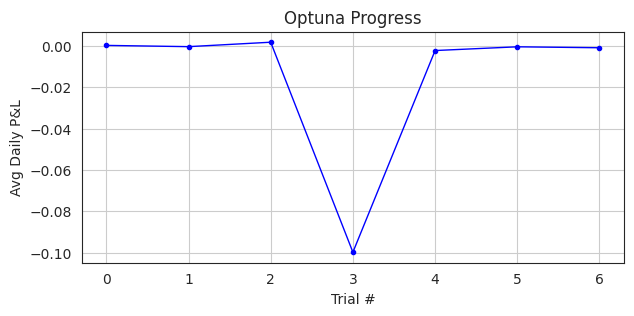

[I 2025-08-24 15:53:14,446] Trial 1 finished with value: -0.00046373339141799044 and parameters: {'pred_threshold': 0.7842457213338009, 'trailing_stop_pred': 0.0791580342930232}. Best is trial 0 with value: 0.00014158135482465777.
[I 2025-08-24 15:58:46,967] Trial 2 finished with value: 0.0016745807013722554 and parameters: {'pred_threshold': 0.6302873025482313, 'trailing_stop_pred': 0.017768599662304985}. Best is trial 2 with value: 0.0016745807013722554.
[I 2025-08-24 16:04:23,523] Trial 3 finished with value: -0.09974036157699841 and parameters: {'pred_threshold': 0.2299976092843683, 'trailing_stop_pred': 0.021617241027736198}. Best is trial 2 with value: 0.0016745807013722554.
[I 2025-08-24 16:09:52,822] Trial 4 finished with value: -0.002340884338923984 and parameters: {'pred_threshold': 0.827961758765252, 'trailing_stop_pred': 0.08014272765508598}. Best is trial 2 with value: 0.0016745807013722554.
[I 2025-08-24 16:15:24,678] Trial 5 finished with value: -0.0005386626007405792 an

KeyboardInterrupt: 

In [26]:
study = optuna.create_study(
    direction      = "maximize",
    pruner         = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12),
    storage        = RDBStorage(
        url="sqlite:///optuna_study.db",
        engine_kwargs={"connect_args": {"timeout": 20, "check_same_thread": False}}
    ),
    load_if_exists = False
)

study.optimize(
    objective,
    n_trials          = n_trials,
    n_jobs            = n_jobs,
    callbacks=[plots.cleanup_callback, plots.lightweight_plot_callback],
    gc_after_trial    = True,
)


In [ ]:
# Final plots & JSON dump (unchanged)...
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

print("Best Parameters       :", study.best_params)
print("Best Average Daily P&L:", study.best_value)

importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s}: {score:.3f}")

first_day = df_train_val.index.normalize().min().strftime("%Y%m%d")
last_day  = df_train_val.index.normalize().max().strftime("%Y%m%d")
file_name = f"{params.ticker}_{first_day}-{last_day}_optuna_predsig_pars_{study.best_value}_{params.model_path}.json"
file_path = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump({
        "best_params": study.best_params,
        "best_value" : study.best_value,
        "importances": importances,
        "trials": [
            {"number": t.number, "value": t.value, "params": t.params, "state": t.state.name}
            for t in study.trials
        ],
    }, f, indent=4)

print(f"\nOptuna results (and importances) saved to: {file_path}")